In [6]:
# Imports
import json 
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Dict
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from typing_extensions import TypedDict
from IPython.display import Image
from pprint import pprint
import os


In [7]:
os.environ['OPENAI_API_KEY'] = 'sk-proj-ITGhy3LPfyvYrxbBci8pT3BlbkFJP5k2rqmOZhAdrOncxu9X'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "<your-api-key>"

## Chains

In [8]:
# Function to create the qa string from the json file
def get_qa_string(json_path):
    with open(json_path) as f:
        data = json.load(f)
    n = len(data)
    qa_string = ""
    for i in range(n):
        q = data[i]['q']
        a = data[i]['a']
        string = "q: " + q + "\n" + "a: " + a
        qa_string += string + "\n"
    return qa_string

In [9]:
qa_string = get_qa_string('filled_form.json')

In [10]:
# Chain for splitting the string 
# Define the Pydantic Object for Function Calling
class SymptomCategory(BaseModel):
    category: str = Field(description="The name of the category")
    questions_and_answers: str = Field(description="The Q&A pairs in that category as a single string")

class CategorizedQA(BaseModel):
    categories: List[SymptomCategory] = Field(description="A list of categorized Q&A pairs")

split_prompt_template = """
You will receive a list of questions and answers on various topics. Your task is to categorize the Q&A pairs into logical categories based on their content.

Here is what you should do:
1. Identify the main topics or categories based on the questions and answers. These categories could be related to symptoms, events, activities, preferences, etc.
2. Group related questions and answers under the appropriate categories. If a question and answer do not fit well into an existing category, create a new category for them.
3. Output the result as a JSON dictionary with the following structure:
{{
  "category": "Category Name",
  "questions_and_answers": {{
    "Vomiting": "q: Question 1\\na: Answer 1\\nq: Question 2\\na: Answer 2",
    "diarrhea": "q: Question 3\\na: Answer 3\\nq: Question 4\\na: Answer 4"
  }}
}}

Here is the list of Q&A pairs:

{input_text}

Please return the categorized Q&A pairs in JSON format with category names as keys and the relevant Q&A pairs as values.
"""

# Create the prompt template
split_prompt = PromptTemplate(input_variables=['input_text'], template=split_prompt_template)

# Initialize the llm
split_llm = ChatOpenAI(model='gpt-4o', temperature=0)
split_structured_llm = split_llm.with_structured_output(CategorizedQA)
categorize_chain = split_prompt | split_structured_llm

split_result = categorize_chain.invoke({'input_text': qa_string})

In [11]:
def parse_split_result(result):
    # Create a dictionary from the parsed result
    categorized_dict: Dict[str, str] = {category.category: category.questions_and_answers for category in result.categories}
    string = ""
    for category in categorized_dict:
        string += "\n"
        qa = categorized_dict[category]
        partial_str = category + ":\n" + qa
        string += partial_str
    return string, categorized_dict

In [12]:
categorized_qa, categorized_dict = parse_split_result(result=split_result)

In [13]:
categorized_dict

{'Symptoms Onset': 'q: When did your symptoms start?\na: Yesterday night',
 'Vomiting': 'q: Do you have vomiting?\na: Yes\nq: Do you see any blood in the vomit?\na: No\nq: Was your vomit green or yellow?\na: Yes',
 'Recreational Drugs': 'q: Have you used any recreational drugs recently?\na: Yes',
 'Motion Sickness': 'q: Have you recently experienced motion sickness from things like amusement park rides, cars, or boats?\na: No',
 'Diarrhea': 'q: Do you have diarrhea?\na: Yes\nq: Does the diarrhea occur when fasting?\na: No\nq: Does the diarrhea occur at night?\na: Yes\nq: Do you experience pain with diarrhea?\na: No\nq: When was your last bowel movement?\na: 3 hours ago\nq: How many bowel movements are you having per 24hr period?\na: 3-4\nq: Is there any blood in your stool?\na: No\nq: Is there any mucus in your stool?\na: Yes\nq: Do you feel as though you have to rush to the bathroom once you have the urge to have a bowel movement?\na: Yes',
 'Travel History': 'q: Have you recently tra

In [14]:
### Split Grader

# Data Model
class SplitGrader(BaseModel):
    """Binary score to assess if the splits are correct or not and if there is any missing information or hallucinations"""

    binary_score: str = Field(
        description="A binary indicator ('correct' or 'incorrect') that evaluates if the Q&A pairs are categorized correctly without any missing information or hallucinations."
    )

# Initialize the llm
split_grader_llm = ChatOpenAI(model='gpt-4o', temperature=0)
split_grader_structured_llm_grader = split_grader_llm.with_structured_output(SplitGrader)

split_grader_system = """You are a grader assessing whether the question answer pairs have been correctly categorized into categories. \n
You must also check if all the questions have been categorized. Check for hallucinations as well. \n
Give a binary score 'correct' or 'incorrect'. 'correct' means that the Q&A pairs are categorized correctly without any missing information or hallucinations.
"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", split_grader_system), 
        ("human", "Q&A Input \n\n {qa_string} \n\n Categorized Q&A: {categorized_qa}")
    ]
)

split_grader = answer_prompt | split_grader_structured_llm_grader
split_grader.invoke({"qa_string": qa_string, "categorized_qa": categorized_qa})

SplitGrader(binary_score='correct')

In [15]:
### Generate Summaries

# Initialize the llm
llm = ChatOpenAI(model='gpt-4o', temperature=0)

summ_system = """
You are given a category and a set of questions and answers related to that category. Your task is to convert these questions and answers into a natural, conversational response as if someone is summarizing their situation based on the answers provided.

Instructions:
1. Use the answers to infer a coherent response that sounds natural and conversational.
2. Incorporate relevant details from both the questions and answers.
3. Avoid directly repeating the questions; instead, focus on integrating the information into a fluid conversation.

Output format:
- The response should be a short, concise paragraph that summarizes the answers in a conversational tone.

Please convert the given category and Q&A pairs into a conversational summary.

Input:
- Category: {category}
- Q&A Pairs:
{q_and_a_pairs}
"""

# Create the prompt template
summ_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", summ_system), 
        ("human", "Category: {category} \n\n Q&A pairs: {q_and_a_pairs}")
    ]
)

summary_chain = summ_prompt | llm | StrOutputParser()

summ_result = summary_chain.invoke({'category': 'Diarrhea', 'q_and_a_pairs': categorized_dict['Diarrhea']})
print(summ_result)


I've been dealing with diarrhea lately, and it's been quite a hassle. It doesn't happen when I'm fasting, but it does wake me up at night. Thankfully, there's no pain involved, but I did have my last bowel movement just three hours ago. On average, I'm going about 3 to 4 times a day. There's no blood in my stool, but I have noticed some mucus. And when I feel the urge, I really have to rush to the bathroom.


In [16]:
### Summaries Grader

# Data Model
class SummaryGrader(BaseModel):
    """Binary score to assess if the response is a natural, conversational response or not and if there is any missing information or hallucinations"""

    binary_score: str = Field(
        description="A binary indicator ('correct' or 'incorrect') that evaluates if the response is a natural, conversational response or not without any missing information or hallucinations."
    )

# Initialize the llm
summ_grader_llm = ChatOpenAI(model='gpt-4o', temperature=0)
summ_grader_structured_llm_grader = summ_grader_llm.with_structured_output(SummaryGrader)

# System Prompt
summ_grader_system = """You are a grader assessing whether the response is a natural, conversational response as if someone is summarizing their situation or not. \n
You must also check if all the questions and answers have been included. Check for hallucinations as well. \n
Give a binary score 'correct' or 'incorrect'. 'correct' means that the Q&A pairs are correctly incorporated in the response without any missing information or hallucinations.
"""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", summ_grader_system), 
        ("human", "Q&A pairs: {q_and_a_pairs} \n\n Response: {response}")
    ]
)

summary_grader = answer_prompt | summ_grader_structured_llm_grader 
summary_grader.invoke({"q_and_a_pairs": categorized_dict['Diarrhea'], "response": summ_result})

SummaryGrader(binary_score='correct')

In [17]:
categorized_dict

{'Symptoms Onset': 'q: When did your symptoms start?\na: Yesterday night',
 'Vomiting': 'q: Do you have vomiting?\na: Yes\nq: Do you see any blood in the vomit?\na: No\nq: Was your vomit green or yellow?\na: Yes',
 'Recreational Drugs': 'q: Have you used any recreational drugs recently?\na: Yes',
 'Motion Sickness': 'q: Have you recently experienced motion sickness from things like amusement park rides, cars, or boats?\na: No',
 'Diarrhea': 'q: Do you have diarrhea?\na: Yes\nq: Does the diarrhea occur when fasting?\na: No\nq: Does the diarrhea occur at night?\na: Yes\nq: Do you experience pain with diarrhea?\na: No\nq: When was your last bowel movement?\na: 3 hours ago\nq: How many bowel movements are you having per 24hr period?\na: 3-4\nq: Is there any blood in your stool?\na: No\nq: Is there any mucus in your stool?\na: Yes\nq: Do you feel as though you have to rush to the bathroom once you have the urge to have a bowel movement?\na: Yes',
 'Travel History': 'q: Have you recently tra

In [18]:
summaries = {}
for category in categorized_dict:
    summ_result = summary_chain.invoke({'category': category, 'q_and_a_pairs': categorized_dict[category]})
    summaries[category] = summ_result
summaries

{'Symptoms Onset': 'I started feeling symptoms just last night.',
 'Vomiting': "I've been experiencing some vomiting lately. Thankfully, there's no blood in it, but the vomit has been green or yellow.",
 'Recreational Drugs': 'Yeah, I have used some recreational drugs recently.',
 'Motion Sickness': "I haven't had any issues with motion sickness lately, whether it's from amusement park rides, cars, or boats.",
 'Diarrhea': "I've been dealing with diarrhea lately, and it's been quite a hassle. It doesn't happen when I'm fasting, but it does wake me up at night. Thankfully, there's no pain involved, but I had my last bowel movement just three hours ago, and I'm going about 3-4 times a day. There's no blood in my stool, but I have noticed some mucus. And when I feel the urge, I really have to rush to the bathroom.",
 'Travel History': "I haven't traveled internationally recently.",
 'Household Symptoms': "It seems like the symptoms I'm experiencing aren't just affecting me; others in my h

In [19]:
incorrect_summary_cats = []
for category in categorized_dict:
    score = summary_grader.invoke({"q_and_a_pairs": categorized_dict[category], "response": summaries[category]})
    grade = score.binary_score
    print(grade)
    if grade == 'correct': 
        print(f'---SUMMARY FOR {category} IS CORRECT---')
        continue
    else:
        print(f'---SUMMARY FOR {category} IS INCORRECT---')
        incorrect_summary_cats.append(category)

correct
---SUMMARY FOR Symptoms Onset IS CORRECT---
correct
---SUMMARY FOR Vomiting IS CORRECT---
correct
---SUMMARY FOR Recreational Drugs IS CORRECT---
correct
---SUMMARY FOR Motion Sickness IS CORRECT---
correct
---SUMMARY FOR Diarrhea IS CORRECT---
correct
---SUMMARY FOR Travel History IS CORRECT---
correct
---SUMMARY FOR Household Symptoms IS CORRECT---
correct
---SUMMARY FOR Symptom Management IS CORRECT---
correct
---SUMMARY FOR Location IS CORRECT---


## Graph

In [20]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        qa_string: Question and answer string (Input to the Model)
    """
    qa_string: str
    categorized_qa: str
    categorized_dict: Dict[str, str]
    summaries: Dict[str, str]
    incorrect_summary_cats: List[str]
    regen_summaries: Dict[str, str]

In [26]:
### Nodes

def split_qa(state):
    print("----SPLITTING INTO CATEGORIES---")
    qa_string = state['qa_string']

    # invoke rag chain
    split_result = categorize_chain.invoke({'input_text': qa_string})
    # Run the function to parse the result
    categorized_qa, categorized_dict = parse_split_result(result=split_result)

    return {"categorized_qa": categorized_qa, "categorized_dict": categorized_dict}

def grade_split(state):
    print("---CHECK IF SPLITS ARE RELEVANT---")
    # Get the categorized_qa and categorized_dict
    categorized_qa = state['categorized_qa']
    categorized_dict = state['categorized_dict']
    # Get the score
    score = split_grader.invoke({"qa_string": qa_string, "categorized_qa": categorized_qa})
    grade = score.binary_score

    # Check is splits are relevant
    if grade == 'correct':
        print('---DECISION: SPLITS ARE RELEVANT---')
        return 'correct splits'
    else:
        return 'incorrect splits'
    
def generate_summaries(state):
    print("---GENERATING SUMMARIES---")
    # Get the categorized dict
    categorized_dict = state['categorized_dict']
    summaries = {}
    for category in categorized_dict:
        summ_result = summary_chain.invoke({'category': category, 'q_and_a_pairs': categorized_dict[category]})
        summaries[category] = summ_result

    return {'summaries': summaries}

def grade_summaries(state):
    print("---GRADING GENERATED SUMMARIES---")
    # Get the categorized dict and the summaries
    categorized_dict = state['categorized_dict']
    summaries = state['summaries']
    incorrect_summary_cats = []
    for category in categorized_dict:
        score = summary_grader.invoke({"q_and_a_pairs": categorized_dict[category], "response": summaries[category]})
        grade = score.binary_score
        if grade == 'correct': 
            print(f'---SUMMARY FOR {category} IS CORRECT---')
            continue
        else:
            print(f'---SUMMARY FOR {category} IS INCORRECT---')
            incorrect_summary_cats.append(category)

    return {'incorrect_summary_cats': incorrect_summary_cats, 'summaries': summaries}

def decide_to_regenerate(state):
    print('---ASSESS WHETHER TO PROCEED OR REGENERATE---')
    # Get the incorrect_summary_cats dict
    incorrect_summary_cats = state['incorrect_summary_cats']
    if not incorrect_summary_cats: 
        print("---DECISION: ALL SUMMARIES ARE CORRECT (PROCEED)---")
        return 'continue'
    else:
        print("---DECISION: SOME SUMMARIES ARE INCORRECT (REGENERATE)---")
        return 'regen summaries'
    
def correct_summaries(state):
    print("---REGENERATING INCORRECT SUMMARIES---")
    # Get the categorized dict, the summaries and the incorrect summaries categories
    categorized_dict = state['categorized_dict']
    summaries = state['summaries']
    incorrect_summary_cats = state['incorrect_summary_cats']
    regen_summaries = {}
    for category in incorrect_summary_cats:
        summ_result = summary_chain.invoke({'category': category, 'q_and_a_pairs': categorized_dict[category]})
        regen_summaries[category] = summ_result
    
    return {'regen_summaries': regen_summaries}

def grade_regen_summaries(state): 
    print("---GRADING REGENERATED SUMMARIES---")
    # Get the categorized dict, regenerated summaries and summaries
    categorized_dict = state['categorized_dict']
    summaries = state['summaries']
    regen_summaries = state['regen_summaries']
    incorrect_summary_cats = []
    for category in regen_summaries:
        score = summary_grader.invoke({"q_and_a_pairs": categorized_dict[category], "response": regen_summaries[category]})
        grade = score.binary_score
        if grade == 'correct':
            print(f'---REGENERATED SUMMARY FOR {category} IS CORRECT---')
            summaries[category] = regen_summaries[category]
            continue
        else:
            print(f'---REGENERATED SUMMARY FOR {category} IS INCORRECT---')
            incorrect_summary_cats.append(category)
    return {'summaries': summaries, 'incorrect_summary_cats': incorrect_summary_cats}

## Build Graph

In [27]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("split_qa", split_qa)
workflow.add_node("generate_summaries", generate_summaries)
workflow.add_node("correct_summaries", correct_summaries)
workflow.add_node("grade_regen_summaries", grade_regen_summaries)
workflow.add_node('grade_summaries', grade_summaries)

# Build the graph
workflow.add_edge(START, 'split_qa')
workflow.add_conditional_edges(
    'split_qa', 
    grade_split, 
    {
        'correct splits': 'generate_summaries',
        'incorrect splits': 'split_qa'
    },
)
workflow.add_edge('generate_summaries', 'grade_summaries')
workflow.add_conditional_edges(
    'grade_summaries', 
    decide_to_regenerate,
    {
        'continue': END,
        'regen summaries': 'correct_summaries'
    }
)
workflow.add_edge('correct_summaries', 'grade_regen_summaries')
workflow.add_conditional_edges(
    'grade_regen_summaries', 
    decide_to_regenerate, 
    {
        'continue': END, 
        'regen summaries': 'correct_summaries'
    }
)

# Compile
app = workflow.compile()

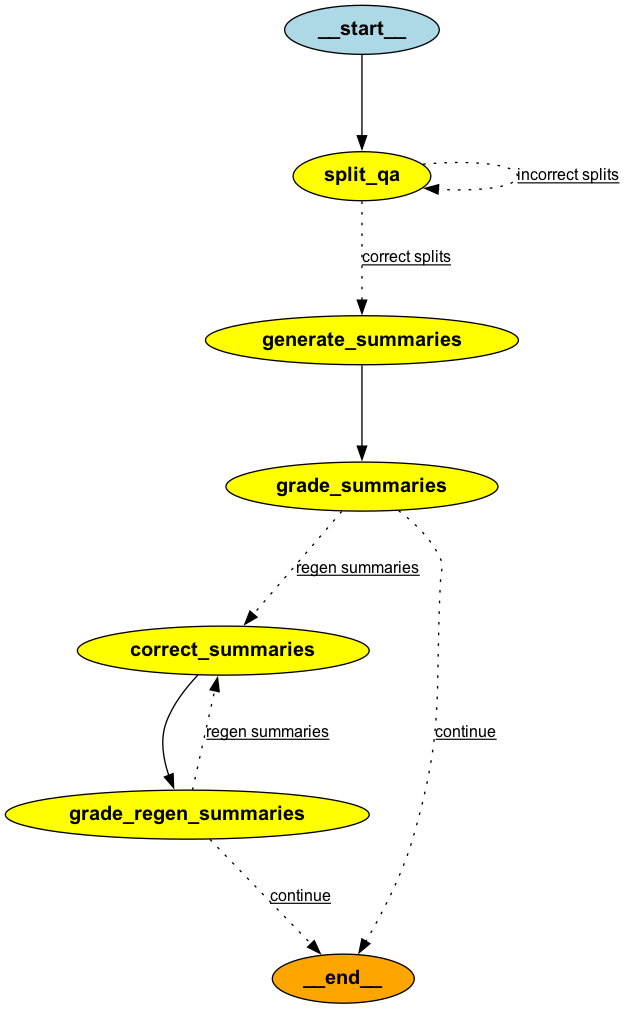

In [28]:
# See the graph
Image(app.get_graph().draw_png())

In [29]:
qa_string

'q: When did your symptoms start?\na: Yesterday night\nq: Do you have vomiting?\na: Yes\nq: Do you see any blood in the vomit?\na: No\nq: Was your vomit green or yellow?\na: Yes\nq: Have you used any recreational drugs recently?\na: Yes\nq: Have you recently experienced motion sickness from things like amusement park rides, cars, or boats?\na: No\nq: Do you have diarrhea?\na: Yes\nq: Does the diarrhea occur when fasting?\na: No\nq: Does the diarrhea occur at night?\na: Yes\nq: Do you experience pain with diarrhea?\na: No\nq: When was your last bowel movement?\na: 3 hours ago\nq: How many bowel movements are you having per 24hr period?\na: 3-4\nq: Is there any blood in your stool?\na: No\nq: Is there any mucus in your stool?\na: Yes\nq: Do you feel as though you have to rush to the bathroom once you have the urge to have a bowel movement?\na: Yes\nq: Have you recently traveled internationally?\na: No\nq: Does anyone else in your household have the same symptoms?\na: Yes\nq: What have yo

In [30]:
inputs = {"qa_string": qa_string}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")
pprint(value['summaries'])

----SPLITTING INTO CATEGORIES---
---CHECK IF SPLITS ARE RELEVANT---
---DECISION: SPLITS ARE RELEVANT---
"Node 'split_qa':"
'\n---\n'
---GENERATING SUMMARIES---
"Node 'generate_summaries':"
'\n---\n'
---GRADING GENERATED SUMMARIES---
---SUMMARY FOR Symptoms Onset IS INCORRECT---
---SUMMARY FOR Vomiting IS INCORRECT---
---SUMMARY FOR Recreational Drugs IS INCORRECT---
---SUMMARY FOR Motion Sickness IS INCORRECT---
---SUMMARY FOR Diarrhea IS INCORRECT---
---SUMMARY FOR Travel History IS INCORRECT---
---SUMMARY FOR Household Symptoms IS INCORRECT---
---SUMMARY FOR Treatment IS INCORRECT---
---SUMMARY FOR Location IS INCORRECT---
---ASSESS WHETHER TO PROCEED OR REGENERATE---
---DECISION: SOME SUMMARIES ARE INCORRECT (REGENERATE)---
"Node 'grade_summaries':"
'\n---\n'
---REGENERATING INCORRECT SUMMARIES---
"Node 'correct_summaries':"
'\n---\n'
---GRADING REGENERATED SUMMARIES---
---REGENERATED SUMMARY FOR Symptoms Onset IS CORRECT---
---REGENERATED SUMMARY FOR Vomiting IS CORRECT---
---REGEN

In [31]:
value['summaries']

{'Symptoms Onset': 'My symptoms actually started just last night.',
 'Vomiting': "I've been experiencing some vomiting lately. Thankfully, there's no blood in it, but the vomit has been green or yellow.",
 'Recreational Drugs': 'Yeah, I have used some recreational drugs recently.',
 'Motion Sickness': "I haven't had any issues with motion sickness lately, whether it's from amusement park rides, cars, or boats.",
 'Diarrhea': "I've been dealing with diarrhea lately, and it's been quite a hassle. It doesn't happen when I'm fasting, but it does wake me up at night. Thankfully, there's no pain involved, but I did have my last bowel movement just three hours ago. On average, I'm going about 3 to 4 times a day. There's no blood in my stool, but I have noticed some mucus. And when I feel the urge, I really have to rush to the bathroom.",
 'Travel History': "I haven't traveled internationally recently.",
 'Household Symptoms': "It seems like the symptoms I'm experiencing aren't just affecting 